## Исследуем пространство семантических эмбеддингов

Для начала, загрузим уже известный нам датасет AG News и предобученные векторы Word2Vec:

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

ds_train, ds_test = tfds.load('ag_news_subset').values()

In [2]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

Для извлечения слов из новостей будем использовать `TextVectorization`:

In [4]:
def extract_text(x):
    return x['title']+' '+x['description']

def tupelize(x):
    return (extract_text(x),x['label'])

vectorizer = keras.layers.experimental.preprocessing.TextVectorization()
vectorizer.adapt(ds_train.take(1500).map(extract_text))

Для начала посмотрим, как выглядят семантические эмбеддинги слов. Пройдёмся по первым 5 новостям, и для каждого слова, которое есть в словаре Word2Vec, запомним его вектор в списке `vects`, а само слово - в `words`:

In [5]:
vects = []
words = []
vocab = vectorizer.get_vocabulary()
for x in ds_train.take(5).map(extract_text):
    for i in vectorizer(x):
        w = vocab[i]
        if w in w2v.index_to_key and w not in words:
            words.append(w)
            w = w2v.get_vector(w)
            vects.append(w)

Теперь применим преобразование PCA для приведения точек к двумерному пространству, и посмотрим на результаты: 

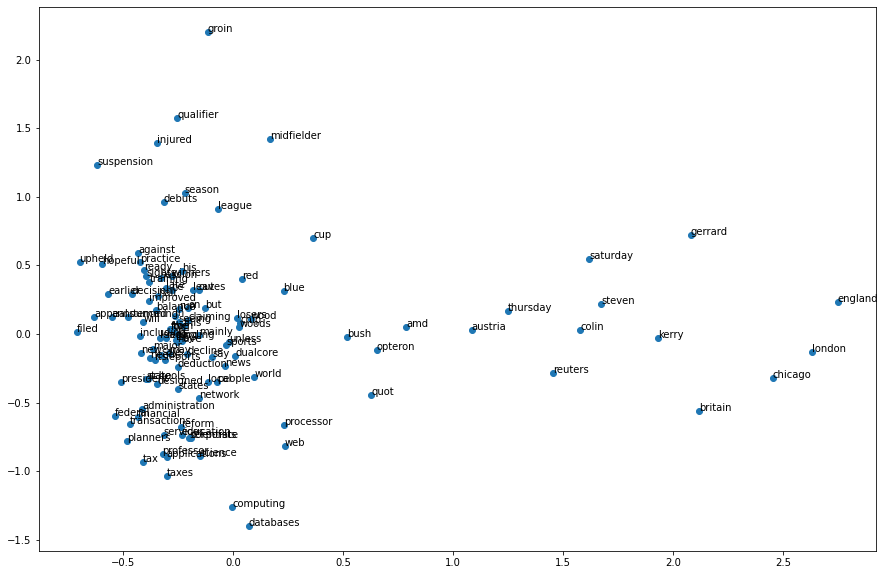

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
res = PCA(n_components=2).fit_transform(vects)
plt.scatter(res[:,0],res[:,1])
for w,c in zip(words,res):
    plt.annotate(w,c)

Можно видеть кластеры семантически-похожих слов, что позволяет сделать вывод о семантической компактности представления Word2Vec.

Далее, посмотрим есть ли некоторая зависимость между средним Word2Vec-вектором новости и её классом. Для этого в список `vects` поместим средние эмбеддинги всех слов из новости, а в массив `cats` - категории новости:

In [8]:
import numpy as np
vects = []
cats = []
news = []
for x,c in ds_train.take(150).map(tupelize):
    m = []
    for i in vectorizer(x):
        w = vocab[i]
        if w in w2v.index_to_key:
            m.append(w2v.get_vector(w))
    vects.append(np.array(m).mean(axis=0))
    cats.append(c)
    news.append(x)

Теперь применим PCA и построим график, отметив разными цветами различные классы новостей:

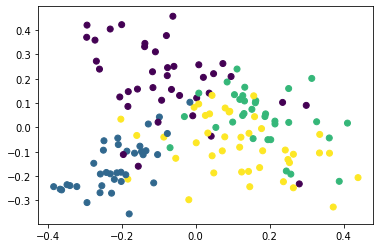

In [9]:
res = PCA(n_components=2).fit_transform(vects)
plt.scatter(res[:,0],res[:,1],c=cats)


Опять же наблюдаем явную кластеризацию новостей одного класса в семантическом пространстве.

Применим кластеризацию в явном виде. Как обычно проведём перебор количества кластеров и посмотрим на значение инерции:

In [13]:
import sklearn.cluster

inertias = []
for k in range(2,10):
    km = sklearn.cluster.KMeans(n_clusters=k).fit(vects)
    inertias.append(km.inertia_)

c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

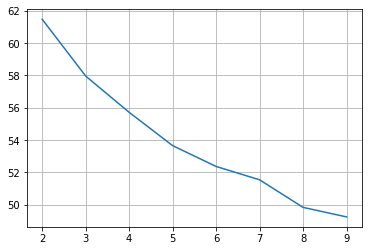

In [14]:
plt.plot(range(2,10),inertias)
plt.grid()

In [25]:
n_clusters = 4
model = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(vects)

c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [26]:
cluster = 0
n=0
for cat,x,clu in zip(cats,news,model.labels_):
    if clu!=cluster:
        continue
    print(f"[{cat}] {x}")
    n+=1
    if n>10:
        break

[3] b'AMD Debuts Dual-Core Opteron Processor AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
[0] b'Sony Banking on MGM Deal to Boost Profits TOKYO - Sony Corp. is banking on the \\$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...'
[3] b'Yahoo Extends Microsoft Ad Deal Yahoo Inc. has agreed to extend its deal to place advertisements on Microsoft Corp. #39;s MSN sites in the United States and overseas by one year through June 2006, Yahoo said on Thursday.'
[3] b'Grokster, Sony BMG to develop legit P2P service? Sony BMG - aka  #39;Bony #39; - the merged music label is in talks with Grokster, the P2P software company has confirmed. Negotiations are believed to be focused on the development of a new, label-friendly P2P network.'
[2] b'Infineon To Build Production Plant In Malaysia  gt;IFX NEW YORK (Dow Jones)--Infineon Technologies AG (IFX) said it will build a 

Хотелось бы каким-то образом понять, есть ли соответствие между категорией новости и кластером. К сожалению, посчитать корреляцию между соответствующими векторами напрямую нельзя, а также оценить количество совпадающих номеров категорий и кластеров, поскольку между номерами кластеров и категорий нет прямого соответствия. Однако, мы можем посчитать матрицу, похожую на матрицу ошибок:

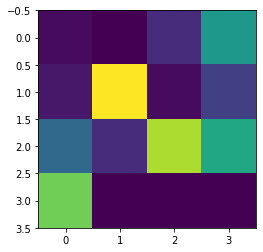

In [27]:
m = np.zeros((n_clusters,4))
for cat,clu in zip(cats,model.labels_):
    m[clu,cat]+=1
plt.imshow(m)